<div style="font-size:30px;"> TLDR:</div>

<div style="font-size:20px;">
Our objective in this project is to predict different house prices.
<br> To accomplish this, we analyzed how different features in the dataset might affect house prices.
<br> We utilized various graphs and plots to visualize the data and identify correlations between the features and the house prices.
<br> Following the data visualization, we explored new hyperparameters to enhance our model's accuracy.
<br> We experimented with different feature selection algorithems and different regulirization methods, in order to achieve the best result.
<br>   
</div>

<div style="font-size:20px;"> Importing the necessary libraries, defining graph attributes and creating the models that will be used:</div>

In [11]:
# import numpy, matplotlib, etc.
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# sklearn imports
import sklearn
from sklearn import metrics
from sklearn import datasets
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV
from sklearn.feature_selection import RFECV, SequentialFeatureSelector

from scipy import stats

# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["legend.title_fontsize"] = 20

# plotly imports
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from IPython.display import display, HTML
#ignore future warnings
import warnings
warnings.filterwarnings('ignore')

<div style="font-size:30px;"> Essential Data Analysis for Regression:</div>

<div style="font-size:20px;"> Loading the train and test datasets:</div>

In [12]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [13]:
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [14]:
    missing_values_train = train.isnull().sum() / len(train) * 100
    missing_values_train = missing_values_train[missing_values_train > 0]
    missing_values_table_train = pd.DataFrame(missing_values_train.sort_values(ascending=False), columns=['Percentage'])
    print("Missing values in percentage - Train")
    print(missing_values_table_train)
    
    missing_values_test = test.isnull().sum() / len(test) * 100
    missing_values_test = missing_values_test[missing_values_test > 0]
    missing_values_table_test = pd.DataFrame(missing_values_test.sort_values(ascending=False), columns=['Percentage'])
    print("\nMissing values in percentage - Test")
    print(missing_values_table_test)

Missing values in percentage - Train
              Percentage
PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
MasVnrType     59.726027
FireplaceQu    47.260274
LotFrontage    17.739726
GarageType      5.547945
GarageYrBlt     5.547945
GarageFinish    5.547945
GarageQual      5.547945
GarageCond      5.547945
BsmtFinType2    2.602740
BsmtExposure    2.602740
BsmtFinType1    2.534247
BsmtCond        2.534247
BsmtQual        2.534247
MasVnrArea      0.547945
Electrical      0.068493

Missing values in percentage - Test
              Percentage
PoolQC         99.794380
MiscFeature    96.504455
Alley          92.666210
Fence          80.123372
MasVnrType     61.274846
FireplaceQu    50.034270
LotFrontage    15.558602
GarageCond      5.346127
GarageYrBlt     5.346127
GarageQual      5.346127
GarageFinish    5.346127
GarageType      5.209047
BsmtCond        3.084304
BsmtExposure    3.015764
BsmtQual        3.015764
BsmtFinType1    2.878684
B

<div style="font-size:20px;"> Dropping columns with more than 45% missing values:</div>

In [15]:
def drop_high_missing_cols(df):
    missing_values = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_values[missing_values > 45].index
    df.drop(columns=columns_to_drop, inplace=True)
    return df

train = drop_high_missing_cols(train)
test = drop_high_missing_cols(test)

<div style="font-size:20px;"> Let's see the different prices of houses of different sizes:</div>

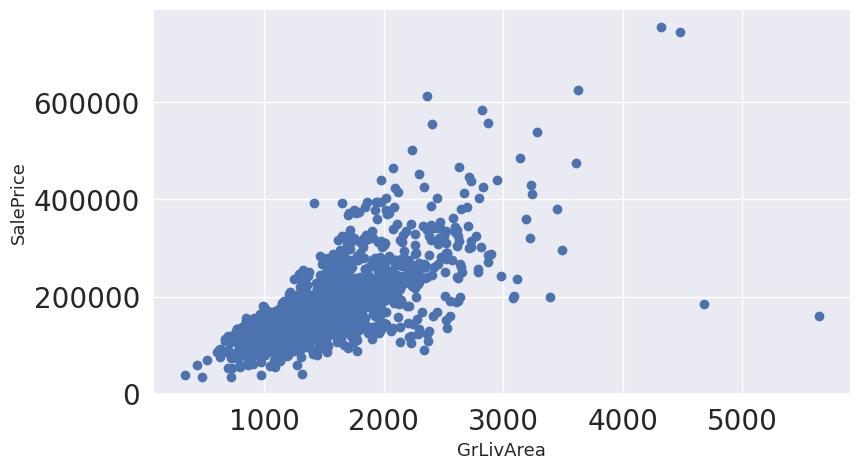

In [16]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

<div style="font-size:20px;"> We can identify a pattern: The price of a dwelling propotional to it's size (which makes sense).
<br>Most of the houses in the data follow that pattern, except 2 outliers at the bottom right corner.
<br> Therefore, we can safely remove them.</div>

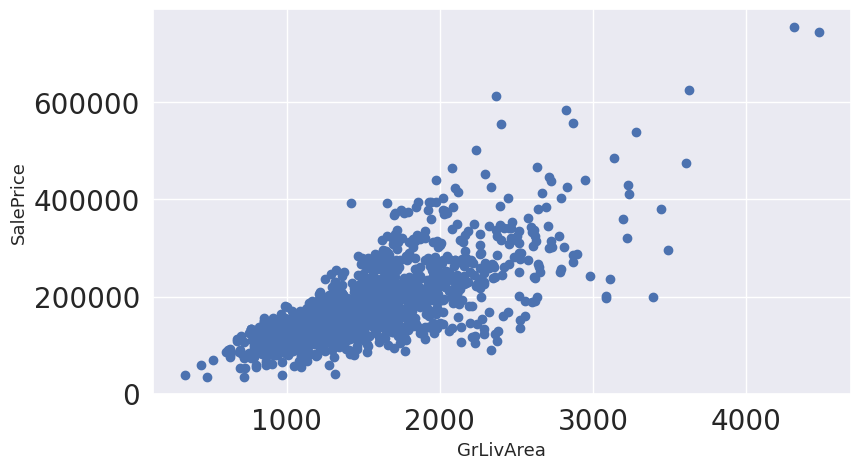

In [17]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

<div style="font-size:20px;"> The two outliers are gone now.</div>

ShapiroResult(statistic=0.869761049747467, pvalue=3.425377313984699e-33)


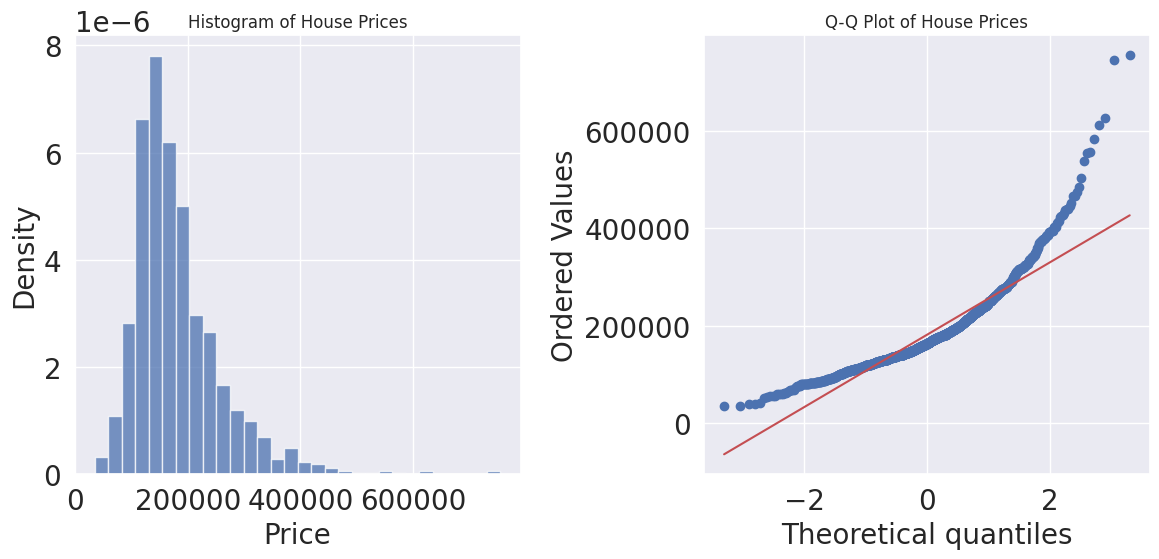

In [18]:
house_prices = train['SalePrice'].values

normality_test = stats.shapiro(house_prices)
print(normality_test)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(house_prices, bins=30, density=True, alpha=0.75, color='b')
axes[0].set_title('Histogram of House Prices')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Density')

stats.probplot(house_prices, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of House Prices')

plt.tight_layout()
plt.show()

<div style="font-size:20px;"> As we can see from the Q-Q plot that the saleprice variable is positively skewed. In order to try and get closer to the normal distribution and hopefully improve the model accuracy, we will apply a logarithmic transformation to the saleprice column. </div>

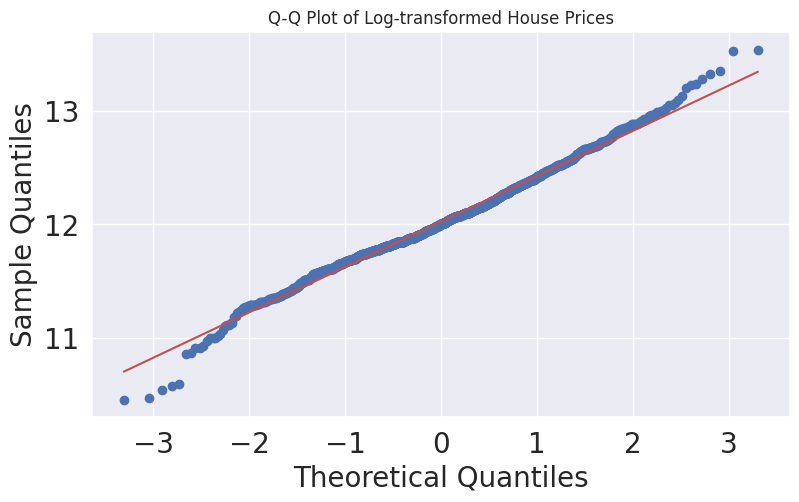

In [19]:
house_prices_log = np.log(house_prices)
stats.probplot(house_prices_log, dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-transformed House Prices')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

<div style="font-size:20px;"> We can see that the Q-Q plot is almost completely linear, which means that now the data distribues almost normally. </div>

<div style="font-size:20px;"> Next we will explore the correlation between the age of a property and it's sale price: </div>

In [20]:
# 5. Calculate Property Age
train['PropertyAge'] = train['YrSold'] - train['YearBuilt']
test['PropertyAge'] = test['YrSold'] - test['YearBuilt']

# Calculate Correlation between Property Age and Sale Price
age_price_corr = train['PropertyAge'].corr(train['SalePrice'])
print(f'Correlation between Property Age and Sale Price: {age_price_corr}')

# Create a scatter plot to visualize the relationship between Property Age and Sale Price
fig = px.scatter(train, x='PropertyAge', y='SalePrice', title='Property Age vs Sale Price', color='PropertyAge', color_continuous_scale=px.colors.sequential.Purp)

fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))

fig.show()

Correlation between Property Age and Sale Price: -0.5240670055640875


<div style="font-size:20px;"> From observing the results, we can see that there's a negative correlation between a property's age and it's price, excluding a few outliers. We will remove them:</div>

In [21]:
train = train.drop(train[(train['PropertyAge']>100) & (train['SalePrice']>250000)].index)
# Create a scatter plot to visualize the relationship between Property Age and Sale Price
fig = px.scatter(train, x='PropertyAge', y='SalePrice', title='Property Age vs Sale Price', color='PropertyAge', color_continuous_scale=px.colors.sequential.Purp)
fig.update_layout(plot_bgcolor='rgb(30,30,30)', paper_bgcolor='rgb(30,30,30)', font=dict(color='white'))
fig.show()

SalePrice        1.000000
OverallQual      0.794024
GrLivArea        0.731900
TotalBsmtSF      0.653808
GarageCars       0.640252
1stFlrSF         0.631428
GarageArea       0.626480
FullBath         0.561921
PropertyAge      0.548861
YearBuilt        0.548550
TotRmsAbvGrd     0.531635
YearRemodAdd     0.508236
MasVnrArea       0.489581
GarageYrBlt      0.488919
Fireplaces       0.466731
BsmtFinSF1       0.418477
LotFrontage      0.370084
WoodDeckSF       0.327108
OpenPorchSF      0.314063
2ndFlrSF         0.311253
HalfBath         0.282232
LotArea          0.265750
BsmtFullBath     0.234829
BsmtUnfSF        0.208507
BedroomAbvGr     0.164688
KitchenAbvGr     0.135732
EnclosedPorch    0.133898
PoolArea         0.100542
ScreenPorch      0.096565
OverallCond      0.095233
MSSubClass       0.087175
LowQualFinSF     0.058001
MoSold           0.047299
3SsnPorch        0.045528
YrSold           0.026583
MiscVal          0.020865
Id               0.017127
BsmtHalfBath     0.015661
BsmtFinSF2  

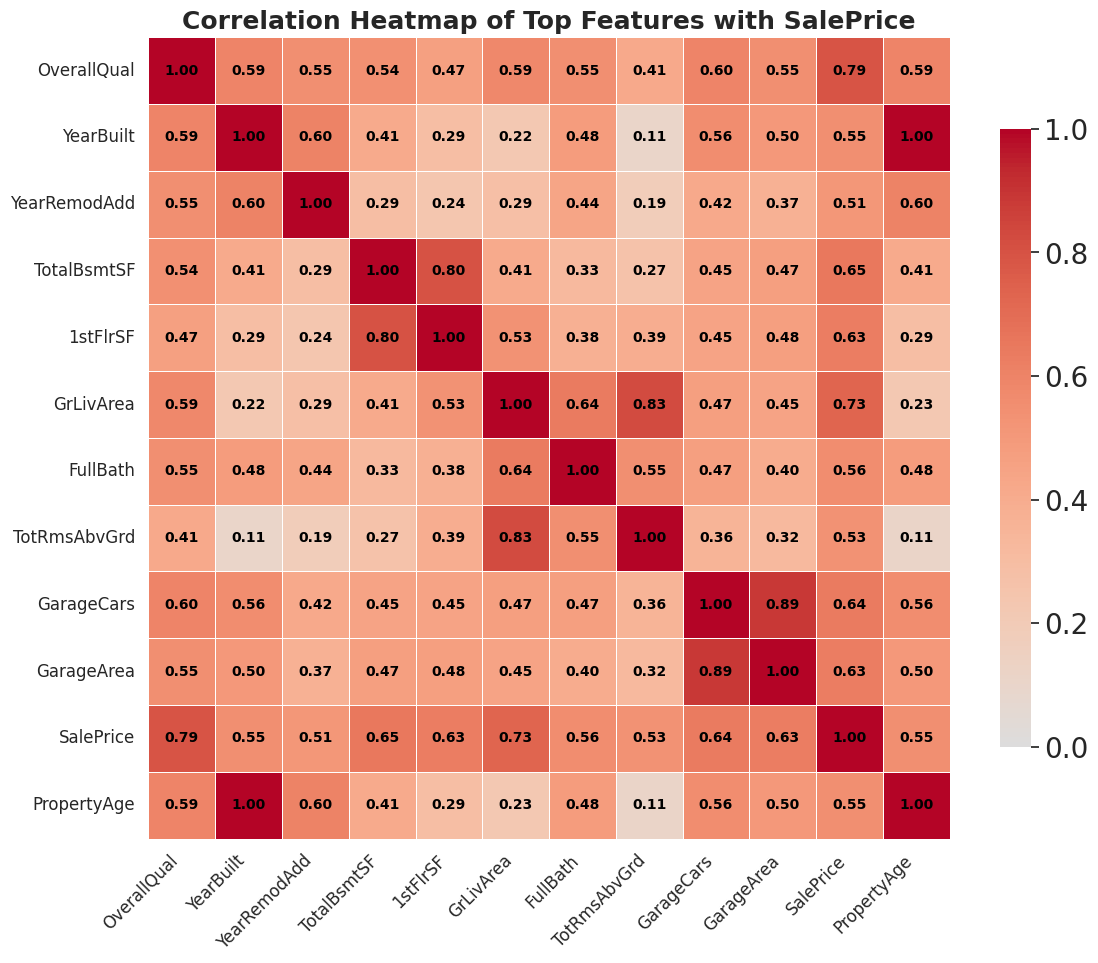

In [22]:
correlation_matrix = train.select_dtypes(include=['int64', 'float64']).corr()
correlation_with_target = correlation_matrix['SalePrice'].abs()
sorted_correlations = correlation_with_target.sort_values(ascending=False)
print(sorted_correlations)
threshold = 0.5

relevant_features = correlation_with_target[correlation_with_target > threshold].index

filtered_correlation_matrix = train[relevant_features].corr().abs()

plt.figure(figsize=(12, 10))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(filtered_correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmax=1.0, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 10, "weight": "bold", "color": "black"})

plt.title('Correlation Heatmap of Top Features with SalePrice', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()

plt.show()

<div style="font-size:25px;"> Feature Engineering:</div>

<div style="font-size:20px;"> Let's try creating new features and see their correlation with the sale price:</div>

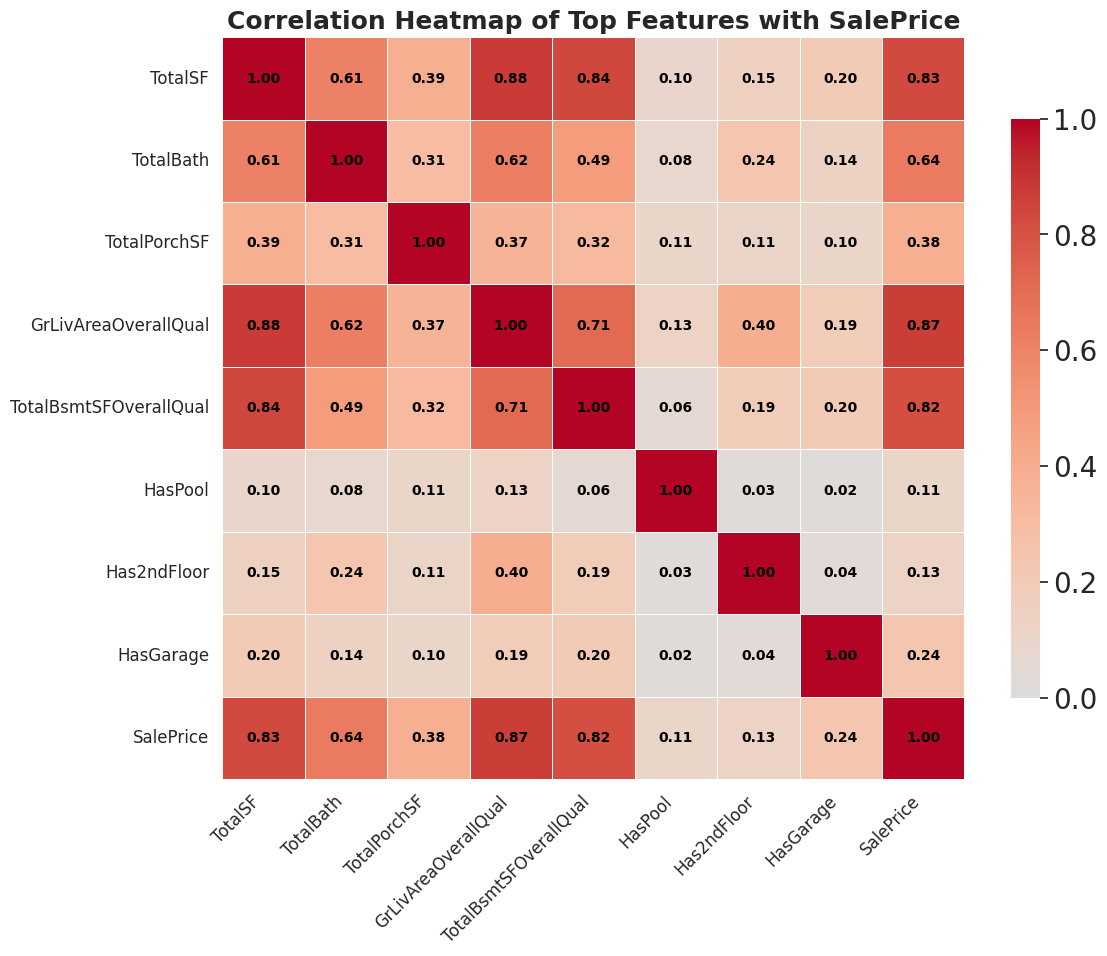

In [23]:
new_features = train.copy()
new_features['TotalSF'] = new_features['TotalBsmtSF'] + new_features['1stFlrSF'] + new_features['2ndFlrSF']
new_features['TotalBath'] = new_features['FullBath'] + new_features['BsmtFullBath'] + 0.5 * (new_features['HalfBath'] + new_features['BsmtHalfBath'])
new_features['TotalPorchSF'] = new_features['OpenPorchSF'] + new_features['3SsnPorch'] + new_features['EnclosedPorch'] + new_features['ScreenPorch'] + new_features['WoodDeckSF']
new_features['GrLivAreaOverallQual'] = new_features['GrLivArea'] * new_features['OverallQual']
new_features['TotalBsmtSFOverallQual'] = new_features['TotalBsmtSF'] * new_features['OverallQual']
new_features['HasPool'] = new_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
new_features['Has2ndFloor'] = new_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
new_features['HasGarage'] = new_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

new_features_list = ['TotalSF', 'TotalBath', 'TotalPorchSF', 'GrLivAreaOverallQual', 'TotalBsmtSFOverallQual', 'HasPool', 'Has2ndFloor', 'HasGarage', 'SalePrice']

correlation_matrix = new_features[new_features_list].corr().abs()

plt.figure(figsize=(12, 10))
cmap = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=cmap, vmax=1.0, vmin=0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75}, annot_kws={"size": 10, "weight": "bold", "color": "black"})
plt.title('Correlation Heatmap of Top Features with SalePrice', fontsize=18, weight='bold')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

<div style="font-size:20px;"> We got new features with high correlation with the target. We will add them to the train dataset and use them:</div>

In [24]:
train['TotalSF'] = new_features['TotalSF']
train['TotalBath'] = new_features['TotalBath']
train['TotalPorchSF'] = new_features['TotalPorchSF']
train['GrLivAreaOverallQual'] = new_features['GrLivAreaOverallQual']
train['TotalBsmtSFOverallQual'] = new_features['TotalBsmtSFOverallQual']
train['HasPool'] = new_features['HasPool']
train['Has2ndFloor'] = new_features['Has2ndFloor']
train['HasGarage'] = new_features['HasGarage']

test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test['TotalBath'] = test['FullBath'] + test['BsmtFullBath'] + 0.5 * (test['HalfBath'] + test['BsmtHalfBath'])
test['TotalPorchSF'] = test['OpenPorchSF'] + test['3SsnPorch'] + test['EnclosedPorch'] + test['ScreenPorch'] + test['WoodDeckSF']
test['GrLivAreaOverallQual'] = test['GrLivArea'] * test['OverallQual']
test['TotalBsmtSFOverallQual'] = test['TotalBsmtSF'] * test['OverallQual']
test['HasPool'] = test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFloor'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasGarage'] = test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

In [25]:
temp = train['SalePrice']
train = train.drop(columns = ['SalePrice'])
train['SalePrice'] = temp

<div style="font-size:25px;"> Feature Selection:</div>

<div style="font-size:20px;"> Firstly, we will clean the data:</div>

In [26]:
#train['SalePrice'] = np.log(train['SalePrice'])
# Split data into features and target
X = train.drop(columns=['SalePrice'])
t = train['SalePrice'].copy()

numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
all_cols = categorical_cols.tolist() + numerical_cols.tolist()

ct_enc_std = ColumnTransformer([
            ("encoding", OrdinalEncoder(), categorical_cols),
            ("standard", MinMaxScaler(), numerical_cols)])

X_encoded = pd.DataFrame(ct_enc_std.fit_transform(X, t), columns=all_cols)
test_encoded = pd.DataFrame(ct_enc_std.fit_transform(test), columns=all_cols)

for col in numerical_cols:
    median_value = X_encoded[col].median()
    med_test = test_encoded[col].median()
    X_encoded[col].fillna(median_value, inplace=True)
    test_encoded[col].fillna(med_test, inplace = True)
    

for col in categorical_cols:
    most_frequent_value = X_encoded[col].mode()[0]
    most_frequent_test = test_encoded[col].mode()[0]
    X_encoded[col].fillna(most_frequent_value, inplace=True)
    test_encoded[col].fillna(most_frequent_test, inplace = True)


<div style="font-size:20px;"> Next, we will use the RFECV for backwards feature selection:</div>

In [27]:
selector = RFECV(
    SGDRegressor(random_state=42),
    cv=RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
    ).fit(X_encoded, t)

display(X_encoded.loc[:, selector.support_])

fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(1, len(selector.feature_names_in_) + 1)],
                         y=selector.cv_results_['mean_test_score']))
fig.update_xaxes(title_text="Number of features selected")
fig.update_yaxes(title_text="Cross validation R2 score")
max_r2_score = np.max(selector.cv_results_['mean_test_score'])
num_features_selected = np.argmax(selector.cv_results_['mean_test_score']) + 1  # +1 because index starts from 0

print(f"Maximum cross-validation R2 score: {max_r2_score}")
print(f"Number of features selected for maximum R2 score: {num_features_selected}")
fig.show()

,Street,LandSlope,ExterQual,BsmtQual,KitchenQual,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,PoolArea,TotalSF,TotalPorchSF,GrLivAreaOverallQual,TotalBsmtSFOverallQual,HasPool
0,1.0,0.0,2.0,2.0,2.0,0.235294,0.150685,0.033420,0.666667,0.500,...,0.000000,0.50,0.394245,0.000000,0.0,0.341389,0.059396,0.261919,0.193665,0.0
1,1.0,0.0,3.0,2.0,3.0,0.000000,0.202055,0.038795,0.555556,0.875,...,0.333333,0.50,0.330935,0.347725,0.0,0.334965,0.290166,0.162923,0.244732,0.0
2,1.0,0.0,2.0,2.0,2.0,0.235294,0.160959,0.046507,0.666667,0.500,...,0.333333,0.50,0.437410,0.000000,0.0,0.362802,0.040896,0.273894,0.208145,0.0
3,1.0,0.0,3.0,3.0,2.0,0.294118,0.133562,0.038561,0.666667,0.500,...,0.333333,0.75,0.461871,0.000000,0.0,0.327164,0.298929,0.263022,0.171041,0.0
4,1.0,0.0,2.0,2.0,2.0,0.235294,0.215753,0.060576,0.777778,0.500,...,0.333333,0.75,0.601439,0.224037,0.0,0.460232,0.268744,0.388286,0.296057,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,1.0,0.0,3.0,2.0,3.0,0.235294,0.140411,0.030929,0.555556,0.500,...,0.333333,0.50,0.330935,0.000000,0.0,0.346589,0.038948,0.214919,0.184809,0.0
1450,1.0,0.0,3.0,2.0,3.0,0.000000,0.219178,0.055505,0.555556,0.625,...,0.666667,0.50,0.359712,0.407235,0.0,0.501835,0.339825,0.272453,0.299030,0.0
1451,1.0,0.0,0.0,3.0,2.0,0.294118,0.154110,0.036187,0.666667,1.000,...,0.666667,0.25,0.181295,0.000000,0.0,0.483022,0.058423,0.361185,0.260633,0.0
1452,1.0,0.0,3.0,3.0,2.0,0.000000,0.160959,0.039342,0.444444,0.625,...,0.000000,0.25,0.172662,0.427071,0.0,0.278678,0.465433,0.113807,0.174208,0.0


Maximum cross-validation R2 score: 0.8725121087566698
Number of features selected for maximum R2 score: 32


In [28]:
X_backward_selected_features=X_encoded.loc[:, selector.support_]
RFECV_selected_features = selector.get_feature_names_out()
print(RFECV_selected_features)
print("number of features: ",len(RFECV_selected_features))



['Street' 'LandSlope' 'ExterQual' 'BsmtQual' 'KitchenQual' 'MSSubClass'
 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'MasVnrArea' 'BsmtFinSF1' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'GrLivArea'
 'BsmtFullBath' 'FullBath' 'HalfBath' 'KitchenAbvGr' 'TotRmsAbvGrd'
 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF' 'PoolArea' 'TotalSF'
 'TotalPorchSF' 'GrLivAreaOverallQual' 'TotalBsmtSFOverallQual' 'HasPool']
number of features:  32


<div style="font-size:20px;"> Next, we will use SequentialFeatureSelector for forward feature selection:</div>

In [29]:
ridge = RidgeCV().fit(X_encoded,t)
sfs_forward = SequentialFeatureSelector(
    ridge,tol=0.001,n_features_to_select='auto',direction="forward"
).fit(X_encoded,t)
selected_feature_indices = np.where(sfs_forward.get_support())[0]

# Get the corresponding column names from X_encoded
sfs_feature_names = X_encoded.columns[selected_feature_indices]
X_forward_selected_features = X_encoded.iloc[:, selected_feature_indices]
ridge_selected = RidgeCV().fit(X_forward_selected_features, t)

# Predict using the fitted model
t_pred = ridge_selected.predict(X_forward_selected_features)

# Calculate the R2 score
r2 = r2_score(t, t_pred)

print(f"R2 score for model with forward sequential selected features: {r2}")

print(
    "Features selected by forward sequential selection: ",
    f"{sfs_feature_names}"
)
print("number of features: ",len(sfs_feature_names))

R2 score for model with forward sequential selected features: 0.9148814023871571
Features selected by forward sequential selection:  Index(['BsmtQual', 'KitchenQual', 'Functional', 'SaleCondition', 'MSSubClass',
       'LotArea', 'OverallQual', 'OverallCond', 'BsmtUnfSF', 'TotalBsmtSF',
       'BedroomAbvGr', 'GarageCars', 'PropertyAge', 'GrLivAreaOverallQual',
       'TotalBsmtSFOverallQual'],
      dtype='object')
number of features:  15


<div style="font-size:20px;"> We can see that the Forward feature selection method produced better results than the bacwards feature selection method for our usecase. Therefore we will probably want to use this method for our submission.</div>

<div style="font-size:25px;"> Regularization:</div> 

<div style="font-size:20px;"> Let's define some functions that will help us to evalute the different regularization methods:</div>

In [30]:
# calculate score and loss from cv (KFold or LPO) and display graphs
def get_cv_score_and_loss(X, t, model, transformer=None,
                          k=None,
                          p=None,
                          show_score_loss_graphs=False):
  
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True,random_state=42)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        # from index to record assignment
        X_train = X.loc[train_ids]
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]

        # fit and predict
        model.fit(X_train, t_train)
        y_train = model.predict(X_train)
        y_val = model.predict(X_val)
        
        # assign results into scores df
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train),
                                                       mean_squared_error(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] =[i, 'val', model.score(X_val, t_val),
                                                      mean_squared_error(t_val, y_val)]

    #split into two dfs , val and train
    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    #calculate mean score and loss for train and validation across all models
    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss: {mean_val_loss:.8f}, Mean Train Loss: {mean_train_loss:.8f}')
        fig.show()
        display(scores_losses_df)


    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss


def estimate_model(X, t, model):
    val_score, val_loss, train_score, train_loss =\
     get_cv_score_and_loss(X, t,
                           model,
                           k=5, show_score_loss_graphs=True)
    print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.8f}')
    print(f'mean cv train score: {train_score:.2f}\nmean cv train loss {train_loss:.8f}')

<div style="font-size:20px;"> Evaluation of each regularization method, based on R2 score and loss:</div>

In [31]:
X_encoded = X_encoded.reset_index(drop=True)
t = t.reset_index(drop=True)

#show_df(X_encoded,"")

sgd_lasso_reg = SGDRegressor(penalty='l1',random_state=42)
sgd_ridge_reg = SGDRegressor(penalty='l2',random_state=42)
sgd_elastic_reg = SGDRegressor(penalty='elasticnet',random_state=42)
print("R2 score for regression:")
print('\nsgd_lasso')
estimate_model(X_encoded, t, make_pipeline(
               StandardScaler(), 
               sgd_lasso_reg))
print('\nsgd_ridge')
estimate_model(X_encoded, t, make_pipeline(
              StandardScaler(), 
             sgd_ridge_reg))
print('\nsgd_elastic')
estimate_model(X_encoded, t, make_pipeline(
              StandardScaler(), 
              sgd_elastic_reg))

R2 score for regression:

sgd_lasso


,fold_id,split,score,loss
0,0,train,0.927468,4.848926e+08
1,0,val,0.885420,4.867612e+08
2,1,train,0.922336,4.347773e+08
3,1,val,0.907163,8.133243e+08
4,2,train,0.922475,4.853766e+08
5,2,val,0.908566,5.650173e+08
6,3,train,0.922817,5.004976e+08
7,3,val,0.890353,5.795582e+08
8,4,train,0.915390,5.226255e+08
9,4,val,0.917804,5.318016e+08


mean cv val score: 0.90
mean cv val loss 595292527.93653703
mean cv train score: 0.92
mean cv train loss 485633931.45118523

sgd_ridge


,fold_id,split,score,loss
0,0,train,0.927450,4.850117e+08
1,0,val,0.885412,4.867947e+08
2,1,train,0.922325,4.348365e+08
3,1,val,0.907134,8.135744e+08
4,2,train,0.922458,4.854829e+08
5,2,val,0.908560,5.650562e+08
6,3,train,0.922807,5.005649e+08
7,3,val,0.890348,5.795830e+08
8,4,train,0.915372,5.227356e+08
9,4,val,0.917779,5.319641e+08


mean cv val score: 0.90
mean cv val loss 595394478.97071850
mean cv train score: 0.92
mean cv train loss 485726316.74645215

sgd_elastic


,fold_id,split,score,loss
0,0,train,0.927453,4.849938e+08
1,0,val,0.885413,4.867897e+08
2,1,train,0.922327,4.348276e+08
3,1,val,0.907138,8.135369e+08
4,2,train,0.922461,4.854670e+08
5,2,val,0.908561,5.650503e+08
6,3,train,0.922809,5.005548e+08
7,3,val,0.890349,5.795793e+08
8,4,train,0.915374,5.227191e+08
9,4,val,0.917782,5.319397e+08


mean cv val score: 0.90
mean cv val loss 595379185.88148415
mean cv train score: 0.92
mean cv train loss 485712456.22417718


<div style="font-size:20px;"> The overall results of all regularization methods are similiar. Thus, we will use Random grid search to choose between them:</div>

In [32]:
# train with grid search and get best parameters
hyper_parameters_backward = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha': [0.0001, 0.001, 0.01, 0.1], 'eta0': [0.001, 0.01, 0.1, 0.5],
                    'learning_rate':['constant']}
gs_model_backward = GridSearchCV(SGDRegressor(random_state=42,max_iter=40000),
                                 hyper_parameters_backward,cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)).fit(X_backward_selected_features, t)
print('best params (backward)', gs_model_backward.best_params_)
estimate_model(X_backward_selected_features,t, gs_model_backward)

print()

hyper_parameters_forward = {'penalty': ('l2', 'l1', 'elasticnet'), 'alpha': [0.0001, 0.001, 0.01, 0.1], 'eta0': [0.001, 0.01, 0.1, 0.5],
                    'learning_rate':['constant']}
gs_model_forward = GridSearchCV(SGDRegressor(random_state=42,max_iter=40000),
                        hyper_parameters_forward,cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)).fit(X_forward_selected_features, t)
print('best params (forward)', gs_model_forward.best_params_)
estimate_model(X_forward_selected_features, t, gs_model_forward)

best params (backward) {'alpha': 0.0001, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'l1'}


,fold_id,split,score,loss
0,0,train,0.885878,7.629283e+08
1,0,val,0.864005,5.777350e+08
2,1,train,0.888280,6.254269e+08
3,1,val,0.869811,1.140555e+09
4,2,train,0.890370,6.863826e+08
5,2,val,0.882404,7.266877e+08
6,3,train,0.890576,7.095678e+08
7,3,val,0.857892,7.511349e+08
8,4,train,0.881804,7.300788e+08
9,4,val,0.900921,6.410292e+08


mean cv val score: 0.88
mean cv val loss 767428462.94568622
mean cv train score: 0.89
mean cv train loss 702876863.00574708

best params (forward) {'alpha': 0.01, 'eta0': 0.001, 'learning_rate': 'constant', 'penalty': 'l1'}


,fold_id,split,score,loss
0,0,train,0.870010,8.690125e+08
1,0,val,0.861412,5.887512e+08
2,1,train,0.868413,7.366467e+08
3,1,val,0.862405,1.205434e+09
4,2,train,0.863196,8.565188e+08
5,2,val,0.876862,7.609286e+08
6,3,train,0.884813,7.469376e+08
7,3,val,0.847470,8.062218e+08
8,4,train,0.865535,8.305688e+08
9,4,val,0.869960,8.413440e+08


mean cv val score: 0.86
mean cv val loss 840535880.39892185
mean cv train score: 0.87
mean cv train loss 807936876.73368454


<div style="font-size:20px;">Sicne both models produced similiar results, we will make submissions using both of them:</div>

<div style="font-size:30px;"> Submissions:</div>

<div style="font-size:20px;"> We will be submitting different results based on various models:</div>

<div style="font-size:20px;"> Submission 1 - Using the model from the grid selection with the features selected by the forward feature selection method:</div>

In [33]:
selected_feature_names = X_forward_selected_features.columns.tolist()
test_encoded = test_encoded[selected_feature_names]
submission['SalePrice'] =gs_model_forward.predict(test_encoded)
submission.to_csv('forward.csv', index=False)
display(submission)

,Id,SalePrice
0,1461,105344.870686
1,1462,160976.346360
2,1463,154116.388924
3,1464,167426.369598
4,1465,173451.272018
...,...,...
1454,2915,61173.346420
1455,2916,57685.431352
1456,2917,155343.305724
1457,2918,103619.340817


<div style="font-size:20px;"> Submission 2 - Using the model from the grid selection with the features selected by the backward feature selection method:</div>

In [34]:
test_encoded = pd.DataFrame(ct_enc_std.fit_transform(test), columns=all_cols)

for col in numerical_cols:
    median_value = X_encoded[col].median()
    med_test = test_encoded[col].median()
    X_encoded[col].fillna(median_value, inplace=True)
    test_encoded[col].fillna(med_test, inplace = True)
    

for col in categorical_cols:
    most_frequent_value = X_encoded[col].mode()[0]
    most_frequent_test = test_encoded[col].mode()[0]
    X_encoded[col].fillna(most_frequent_value, inplace=True)
    test_encoded[col].fillna(most_frequent_test, inplace = True)

selected_feature_names = X_backward_selected_features.columns.tolist()
test_encoded = test_encoded[selected_feature_names]
submission['SalePrice'] = gs_model_backward.predict(test_encoded)
submission.to_csv('backward.csv', index=False)
display(submission)

,Id,SalePrice
0,1461,93638.220248
1,1462,137979.264075
2,1463,149872.750290
3,1464,161350.133789
4,1465,150368.555042
...,...,...
1454,2915,56550.536584
1455,2916,57835.126581
1456,2917,150287.602057
1457,2918,83749.344837


<div style="font-size:20px;"> Submission 3 - Using sfs with the features selected by it:</div>

In [35]:
test_encoded = pd.DataFrame(ct_enc_std.fit_transform(test), columns=all_cols)

for col in numerical_cols:
    median_value = X_encoded[col].median()
    med_test = test_encoded[col].median()
    X_encoded[col].fillna(median_value, inplace=True)
    test_encoded[col].fillna(med_test, inplace = True)
    

for col in categorical_cols:
    most_frequent_value = X_encoded[col].mode()[0]
    most_frequent_test = test_encoded[col].mode()[0]
    X_encoded[col].fillna(most_frequent_value, inplace=True)
    test_encoded[col].fillna(most_frequent_test, inplace = True)

test_encoded = test_encoded[sfs_feature_names]
submission['SalePrice'] = ridge_selected.predict(test_encoded)
submission.to_csv('sfs.csv', index=False)
display(submission)

,Id,SalePrice
0,1461,113807.210268
1,1462,151231.793460
2,1463,168166.972607
3,1464,167595.738594
4,1465,140184.387693
...,...,...
1454,2915,77067.547586
1455,2916,58477.812403
1456,2917,146868.272237
1457,2918,106113.549111


<div style="font-size:20px;"> 
    Screenshots of our last 10 submissions and our placement on the leaderbord:
</div>

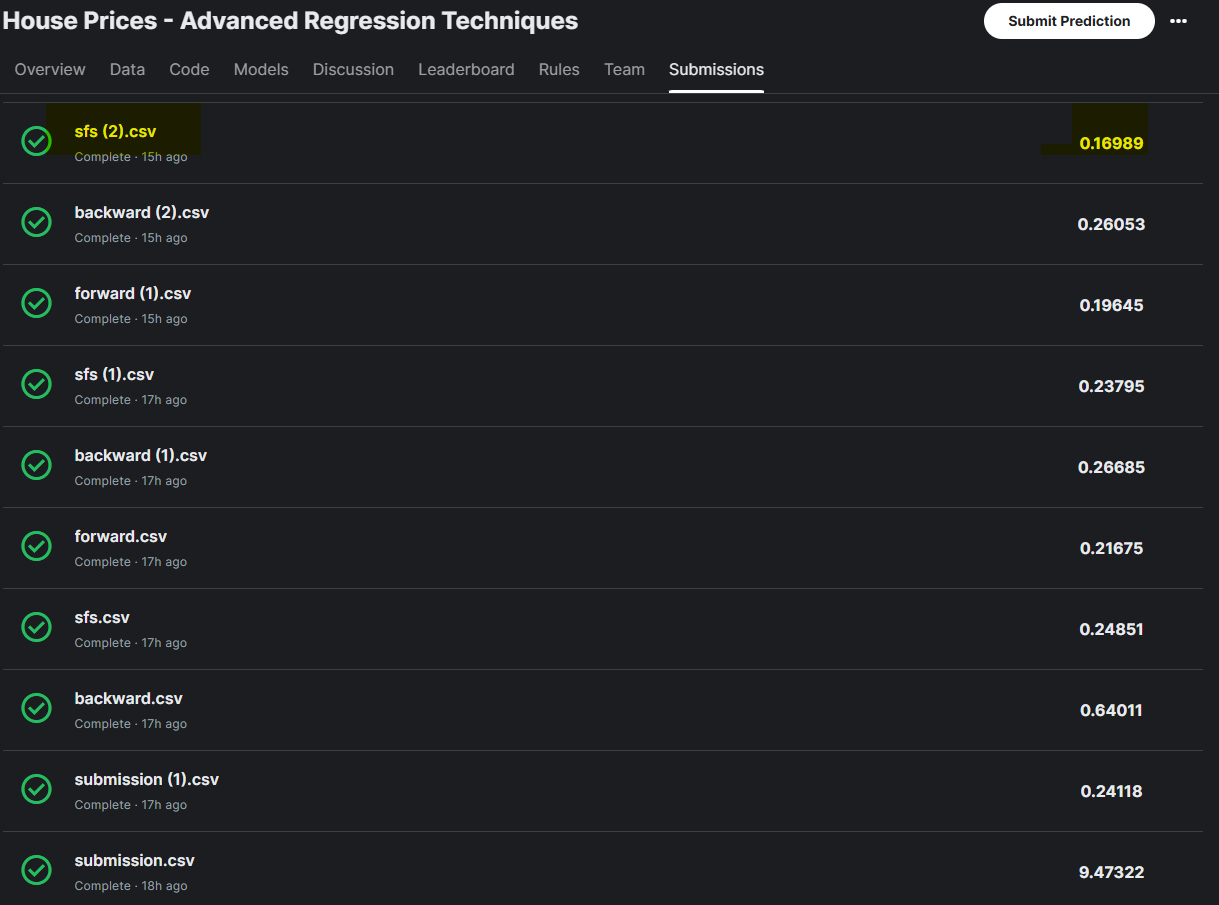

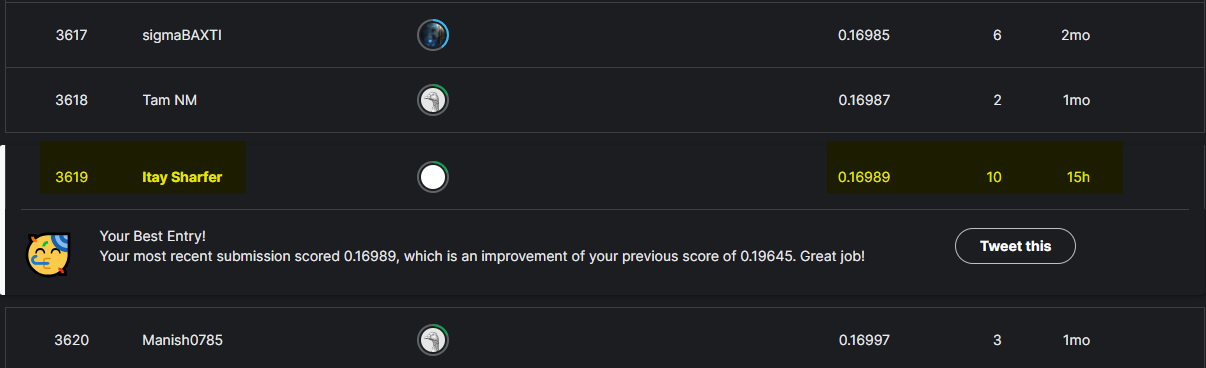

<div style="font-size:30px;"> Summary:</div>

<div style="font-size:20px;"> 
    After analyzing the data, we discovered a connection between GrLiveArea, the age of the property, and the target variable.
    <br>The new features created during the feature engineering process helped to improve the model's accuracy.
    <br>Both feature selection methods yielded similar results, as did the grid search, so we used both approaches for our submissions.
    <br>We trained all the models on both normalized and non-normalized target variables.
    <br>Surprisingly, the non-normalized target variable produced better results.
    <br>Our best performance was achieved using the SequentialFeatureSelector, with a score of 0.16989.
</div>

<div style="font-size:30px;"> References:</div>

<div style="font-size:20px;">
       Data analysis:
<br>1. <a href="https://www.kaggle.com/code/kenjee/housing-prices-example-with-video-walkthrough"> Kaggle notebook</a>
<br>2. <a href="https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard#Data-Processing">Kaggle notebook</a>
<br>Video walkthrough:
<br>3.<a href="https://www.youtube.com/watch?v=NQQ3DRdXAXE&t=1098s&ab_channel=KenJee"> Video</a>
<br> Python functions and library functions were taken from the notebooks provided by the course.
</div>

# Exercise 4

<div style="font-size:30px;"> TLDR:</div>

<div style="font-size:20px;"> In this exercise, we aim to improve the model performance from exercise 2 by using different models, including LWLR, KNN, SVR, and Decision Trees.
    <br>Each of these models will be trained and evaluated individually to understand their strengths and weaknesses.
    <br>We will then experiment with various ensemble methods, such as Bagging and Boosting, to enhance overall performance and mitigate potential overfitting or underfitting.
    <br>After comparing the results of these ensemble methods, we will combine the most promising ones into a voting regressor, taking advantage of the diversity of the models to improve accuracy and robustness.
    <br>Finally, we will submit the predictions from the voting regressor to evaluate its effectiveness in comparison to individual models and ensemble methods used earlier.
</div>

<div style="font-size:20px;"> In exercise 2, we achieved the best results by using sfs. We will continue to use the features selected by it in this exercise in order to try and achieve the best results.</div>

In [36]:
!git clone https://github.com/qiaochen/CourseExercises

Cloning into 'CourseExercises'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24 (from 1)
Unpacking objects: 100% (24/24), 248.83 KiB | 1.94 MiB/s, done.


In [37]:
import math
import numpy as np
import pandas as pd
from CourseExercises.lwlr import LWLR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, RepeatedKFold, KFold, LeavePOut, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor  
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

<div style="font-size:20px;"> Functions that will be used later:</div>

In [38]:
def drop_high_missing_cols(df):
    missing_values = df.isnull().sum() / len(df) * 100
    columns_to_drop = missing_values[missing_values > 45].index
    df.drop(columns=columns_to_drop, inplace=True)
    return df

def preprocess(df):
    df = drop_high_missing_cols(df)
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numeric_transformer_impute = SimpleImputer(strategy='mean')
    categorical_transformer_impute = SimpleImputer(strategy='most_frequent')

    df[numeric_features] = numeric_transformer_impute.fit_transform(df[numeric_features])
    df[categorical_features] = categorical_transformer_impute.fit_transform(df[categorical_features])

    numeric_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Transform the data
    df_preprocessed = preprocessor.fit_transform(df)

    # If the result is a sparse matrix, convert it to a dense array
    if hasattr(df_preprocessed, "toarray"):
        df_preprocessed = df_preprocessed.toarray()

    # Get feature names
    numeric_feature_names = numeric_features
    categorical_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numeric_feature_names) + list(categorical_feature_names)

    # Convert to DataFrame
    df_preprocessed = pd.DataFrame(df_preprocessed, columns=feature_names)
    return df_preprocessed

In [39]:
# calculate score and loss from cv (KFold or LPO) and display graphs
def get_cv_score_and_loss(X, t, model, transformer=None,
                          k=None,
                          p=None,
                          show_score_loss_graphs=False):
  
    scores_losses_df = pd.DataFrame(columns=['fold_id', 'split', 'score', 'loss'])

    if k is not None:
        cv = KFold(n_splits=k, shuffle=True,random_state=42)
    elif p is not None:
        cv = LeavePOut(p)
    else:
        raise ValueError('you need to specify k or p in order for the cv to work')

    for i, (train_ids, val_ids) in enumerate(cv.split(X)):
        # from index to record assignment
        X_train = X.loc[train_ids]
        t_train = t.loc[train_ids]
        X_val = X.loc[val_ids]
        t_val = t.loc[val_ids]

        # fit and predict
        model.fit(X_train, t_train)
        y_train = model.predict(X_train)
        y_val = model.predict(X_val)
        
        # assign results into scores df
        scores_losses_df.loc[len(scores_losses_df)] = [i, 'train', model.score(X_train, t_train),
                                                       r2_score(t_train, y_train)]
        scores_losses_df.loc[len(scores_losses_df)] =[i, 'val', model.score(X_val, t_val),
                                                      r2_score(t_val, y_val)]

    #split into two dfs , val and train
    val_scores_losses_df = scores_losses_df[scores_losses_df['split']=='val']
    train_scores_losses_df = scores_losses_df[scores_losses_df['split']=='train']

    #calculate mean score and loss for train and validation across all models
    mean_val_score = val_scores_losses_df['score'].mean()
    mean_val_loss = val_scores_losses_df['loss'].mean()
    mean_train_score = train_scores_losses_df['score'].mean()
    mean_train_loss = train_scores_losses_df['loss'].mean()

    if show_score_loss_graphs:
        fig = px.line(scores_losses_df, x='fold_id', y='score', color='split', title=f'Mean Val Score: {mean_val_score:.2f}, Mean Train Score: {mean_train_score:.2f}')
        fig.show()
        fig = px.line(scores_losses_df, x='fold_id', y='loss', color='split', title=f'Mean Val Loss: {mean_val_loss:.8f}, Mean Train Loss: {mean_train_loss:.8f}')
        fig.show()
        display(scores_losses_df)


    return mean_val_score, mean_val_loss, mean_train_score, mean_train_loss


def estimate(X, t, model):
    val_score, val_loss, train_score, train_loss =\
     get_cv_score_and_loss(X, t,
                           model,
                           k=5, show_score_loss_graphs=True)
    print(f'mean cv val score: {val_score:.2f}\nmean cv val loss {val_loss:.8f}')
    print(f'mean cv train score: {train_score:.2f}\nmean cv train loss {train_loss:.8f}')

In [40]:
# This function uses gridsearch to achieve the best results for the given model and hyperparameters
def test_model(df, t, hyperparams, model):
    arr_X_normalized = np.asarray(df)
    gs_model = GridSearchCV(model, hyperparams, scoring="r2").fit(arr_X_normalized, t)
    model_name = type(model).__name__
    print(f'{model_name} best score: {gs_model.best_score_}')
    print('Best params:', gs_model.best_params_)
    
    return gs_model

<div style="font-size:20px;"> We're using PCA to reduce the dimensionality of the dataset while preserving its most significant features, and we selected 0.9 as the threshold for n_components to ensure that 90% of the variance is retained. We will test the models on the dataset before and after the PCA conversion to see its effect.</div>

In [41]:
pca = PCA(n_components=0.9).fit(X_forward_selected_features)
X_pca = pd.DataFrame(pca.transform(X_forward_selected_features))

<div style="font-size:30px;"> Model testing:</div>

<div style="font-size:20px;"> In this section, we will compare between the following models: LWLR, KNN, Descision Trees and SVM. We will be using them with grid search in order to get the best hyper parameters.
<br> For each model, we will first use it with grid search to get the best hyper parameters. Afterwards, we will try running it while using PCA with different n-componnents values.
<br> We will check each model with and without using PCA, to see the impact of PCA on our model performance.
</div>

<div style="font-size:20px;"> KNN:
<br>A non-parametric, instance-based algorithm, meaning it doesn’t learn a model explicitly during training.
<br>Instead, it stores the training data and makes predictions based on it.
<br>For a given input, KNN finds the k closest training examples in the feature space. 
<br>In regression, the prediction for a new data point is typically the average of the target values of its k nearest neighbors.</div>

In [42]:
knn = KNeighborsRegressor()
hyper_parameters = {
    'n_neighbors': list(range(1, 10)),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn_gs = test_model(X_forward_selected_features, t, hyper_parameters, knn)

KNeighborsRegressor best score: 0.7920762182526732
Best params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


<div style="font-size:20px;">
The KNN model achieved a best R² score of 0.7921. The optimal hyperparameters found through GridSearchCV were:

- **Metric**: Manhattan
- **Number of Neighbors (n_neighbors)**: 3
- **Weights**: Distance
</div>

<div style="font-size:20px;"> LWLR:
<br>A variant of linear regression where the model gives different weights to different training examples based on their distance from the query point.
    <br>Closer points are given more weight, making the regression locally weighted.
    <br>A kernel function is then used to assign weights to each training point based on its distance to the query point.
    <br>The model then fits a linear regression line to these weighted points.
</div>

In [43]:
lwlr = LWLR(k = 1)
hyperparams = {'k': list(range(1, 10))}
lwlr_gs = test_model(X_forward_selected_features, t, hyperparams,lwlr)

LWLR best score: 0.9177941206531888
Best params: {'k': 2}


<div style="font-size:20px;">
The LWLR model achieved a best R² score of 0.9178. The optimal hyperparameter found through GridSearchCV was:

- **k**: 2
    </div>

<div style="font-size:20px;"> Decision Tree:
<br>A non-parametric, tree-based model that splits the data into subsets based on feature values.
<br>The splits are chosen to minimize a loss function in the resulting subsets.
<br>In regression, the average of the target values in the leaf node is used as the prediction.
<br>The tree grows by recursively splitting the data until it meets a stopping criterion.
<br>For a new input, the model traverses the tree according to the feature values until it reaches a leaf node, where it outputs the average target value.
</div>

In [44]:
descision_tree = DecisionTreeRegressor()
hyperparameters = {
   'max_depth': list(range(1,25)),
    'min_samples_split': list(range(1,15)),
    'min_samples_leaf': list(range(1,5))
}
tree_gs = test_model(X_forward_selected_features, t, hyperparameters,descision_tree)

DecisionTreeRegressor best score: 0.8114054350191235
Best params: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}


<div style="font-size:20px;">
The DecisionTreeRegressor model achieved a best R² score of 0.8115. The optimal hyperparameters found through GridSearchCV were:

- **Max Depth**: 9
- **Minimum Samples Leaf**: 2
- **Minimum Samples Split**: 7
</div>

<div style="font-size:20px;">SVM:
<br>In SVM for regression (SVR), the goal is to find a function that has at most a certain error (epsilon) for all training points and is as flat as possible.
<br>SVR can be linear or non-linear. In the non-linear case, SVR uses different kernels to map input features into a higher-dimensional space where a linear regression can fit the data.
<br>SVR predicts by solving an optimization problem that balances the model complexity (flatness of the function) and the deviation of predictions from the actual targets within the allowed epsilon.
    </div>

In [45]:
svr = SVR()
hyperparams = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svr_gs = test_model(X_forward_selected_features, t, hyperparams ,svr)

SVR best score: 0.7896780106517287
Best params: {'C': 1000, 'gamma': 'auto', 'kernel': 'poly'}


<div style="font-size:20px;">
    The Support Vector Regression (SVR) model achieved a best R² score of 0.7897. The optimal hyperparameters found through GridSearchCV were:

- **C**: 1000
- **Gamma**: auto
- **Kernel**: polynomial
    </div>

<div style="font-size:20px;">
    After experimenting with all the models, we can see that LWLR provided the best results.
    <br>In the context of the Kaggle house prices task, LWLR likely performed best due to its ability to adapt to local patterns and complex, non-linear relationships in the data. The house prices dataset often features varying relationships between predictors and the target variable across different regions, such as neighborhoods with different price dynamics. LWLR's approach of fitting local linear models around each prediction point allows it to capture these variations more effectively than global models. Additionally, its focus on nearby data points helps it handle varying densities and localized trends, which are common in housing data, making it more robust and better suited for this particular task than models like SVR, KNN, or Decision Trees. 
    </div>
 

<div style="font-size:30px;">
PCA:
    </div>

<div style="font-size:20px;">
    Next, let's try to to use PCA in order to try and improve our results.
    <br>Applying PCA might improve our results by reducing the dimensionality of the dataset, which can help eliminate noise, enhance the most informative features, and improve the performance and generalization of your regression models.
    </div>
 

In [46]:
pipeline = Pipeline([
    ('pca', PCA()),
    ('lwlr', lwlr_gs.estimator)
])
hyper_params_pca = {
    'pca__n_components': [0.90, 0.95, 0.99],  
    'lwlr__k': lwlr_gs.param_grid['k']  
}
lwlr_pca = test_model(X_forward_selected_features, t, hyper_params_pca, pipeline)

Pipeline best score: 0.8495823333664567
Best params: {'lwlr__k': 1, 'pca__n_components': 0.99}


<div style="font-size:20px;">
    Getting worse results with PCA could be due to several reasons:
<br>1. In this dataset, certain features have complex, non-linear relationships with the target variable - the price. PCA assumes linear relationships between features, so it might not preserve these interactions effectively, causing a drop in model performance.
<br>2. LWLR is highly sensitive to the local structure of the data. By applying PCA, the local neighborhood structure could be altered, reducing the effectiveness of the model, which relies on proximity and local relationships between data points.
    </div>
 

<div style="font-size:30px;">
   Ensembles methods
    </div>

<div style="font-size:20px;">
    Next, we will try using different ensembles methods in order to try and improve our results. We will use Bagging and Boosting ensembles with different models. Afterwards, we will combine them into a voting regressor in order to try and improve the accuracy.
    </div>

<div style="font-size:20px;">
Firstly, let's try using the lwlr model from above with bagging - a technique used to improve the accuracy and stability of models, particularly in reducing variance. It works by training multiple models on different subsets of the training data and averaging their predictions. 
    </div>

In [47]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import GridSearchCV

bagging_lwlr = BaggingRegressor(base_estimator=lwlr_gs.estimator, random_state=42)
param_grid = {
   'n_estimators': [10, 50],
   'max_samples': [0.7, 1.0],
   'max_features': [0.7, 1.0]
}

bagging_gs = GridSearchCV(bagging_lwlr, param_grid, scoring='r2', cv=3)
bagging_gs.fit(X_forward_selected_features, t)

print('Bagging LWLR best score:', bagging_gs.best_score_)
print('Best params:', bagging_gs.best_params_)


Bagging LWLR best score: 0.9121808450649587
Best params: {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


<div style="font-size:20px;">
    Next, Let's try using random forest (bagging-based ensemble) by taking into account the best parameters of the decision tree testing from earlier.
    <br>Random forest builds multiple decision trees during training and combines their results to improve the model's overall performance and reduce overfitting.
    <br>The best result was achieved when using max_depth = 6, min_sample_leaf = 2, min_sample_split = 3.
    </div>

In [48]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor()
hyperparams = {
    'n_estimators': [100, 150, 200],  
    'max_depth': [6],        
    'min_samples_split': [3], 
    'min_samples_leaf': [2],    
    'max_features': ['auto', 'sqrt'],
}
rand_forest = test_model(X_forward_selected_features, t, hyperparams, rf)

RandomForestRegressor best score: 0.8725983895118865
Best params: {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}


<div style="font-size:20px;">
    Here, we're trying bagging with SGDRegressor:
    </div>

In [49]:
from sklearn.ensemble import BaggingRegressor

bag_fold_model = BaggingRegressor(estimator=SGDRegressor(random_state=42, max_iter=40000),
                                   n_estimators=20, random_state=42,
                                   bootstrap=False).fit(X_forward_selected_features, t)

print('R2 score for regressor:')
print('bag_fold_model', bag_fold_model.score(X_forward_selected_features, t).mean())

R2 score for regressor:
bag_fold_model 0.8679091872607316


<div style="font-size:20px;">
    Let's try bagging with bootstrap:
    </div>

In [50]:
bag_boot_model = BaggingRegressor(estimator=SGDRegressor(random_state=42, max_iter=40000),
                                   n_estimators=20, random_state=42,
                                   bootstrap=True).fit(X_forward_selected_features, t)

print('R2 score for regressor:')
print('bag_boot_model', bag_boot_model.score(X_forward_selected_features, t).mean())

R2 score for regressor:
bag_boot_model 0.8581181729257191


<div style="font-size:20px;">
    Next, we will try using Desicion tree with boosting, and see if we can get a better score than the random forest we tried earlier:
    </div>

In [51]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X, y = X_forward_selected_features,t


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


tree = DecisionTreeRegressor(max_depth=3)


adaboost_regressor = AdaBoostRegressor(base_estimator=tree, n_estimators=50, random_state=42)


adaboost_regressor.fit(X_train, y_train)


y_pred = adaboost_regressor.predict(X_test)


print(f'R2 Score: {r2_score(y_test, y_pred)}')


R2 Score: 0.8192066679604013


<div style="font-size:20px;">
Let's try using gradient boosting:
    </div>

In [54]:
from sklearn.ensemble import GradientBoostingRegressor

gb_regressor = GradientBoostingRegressor(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1], 
    'max_depth': [3, 4, 5],  
    'subsample': [0.8, 1.0],  
    'min_samples_split': [2, 5, 10] 
}

gb_gs = test_model(X_forward_selected_features, t, param_grid ,gb_regressor)

GradientBoostingRegressor best score: 0.9082585444590224
Best params: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.8}


<div style="font-size:20px;">
    Let's compare the scores of all the models we tested so far:
    </div>

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
480 fits failed out of a total of 6720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 1247, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _va

Text(0.5, 1.0, 'CV Negative RMSE Scores')

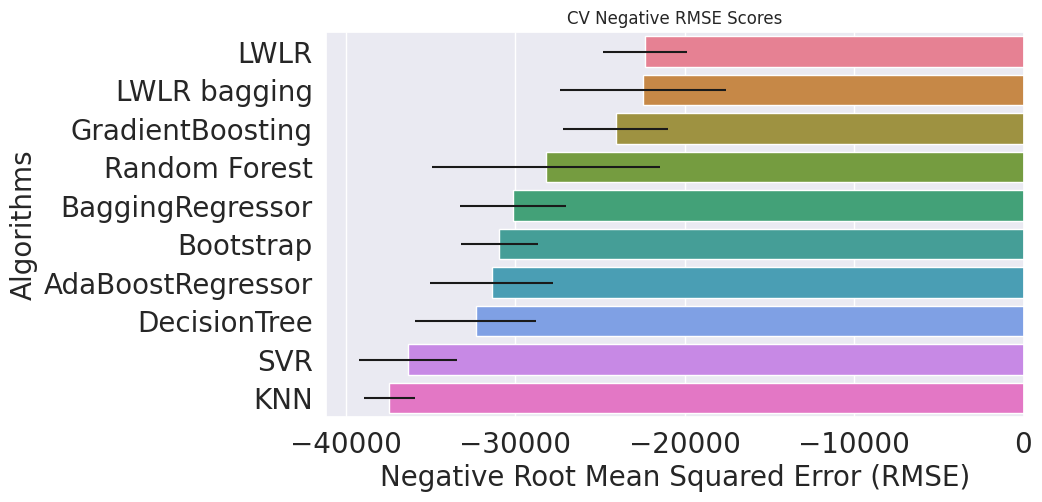

In [56]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import seaborn as sns


arr_X= np.asarray(X_forward_selected_features)

K_fold = KFold(n_splits=5, shuffle=True, random_state=42)

models = [] 
cv_results = [] 
cv_means = []
cv_std = [] 

models.append(lwlr_gs)
models.append(knn_gs)
models.append(tree_gs)
models.append(svr_gs)
models.append(rand_forest)
models.append(bagging_gs)
models.append(bag_boot_model)
models.append(bag_fold_model)
models.append(adaboost_regressor)
models.append(gb_gs)


for model in models:
    cv_results.append(cross_val_score(model, arr_X, t, 
                                       scoring="neg_root_mean_squared_error", cv=K_fold, n_jobs=6))

for cv_result in cv_results:
    cv_means.append(cv_result.mean())  
    cv_std.append(cv_result.std())  

cv_frame = pd.DataFrame(
    {
        "CrossValMeans": cv_means,
        "CrossValErrors": cv_std,
        "Algorithms": ["LWLR",
                     "KNN", 
                     "DecisionTree",
                     "SVR", 
                     "Random Forest",
                     "LWLR bagging", 
                     "Bootstrap",   
                     "BaggingRegressor",
                      "AdaBoostRegressor",
                      "GradientBoosting"]
    })

cv_plot = sns.barplot(x="CrossValMeans", y="Algorithms", data=cv_frame,
                      palette="husl", orient="h", **{'xerr': cv_std},
                      order=cv_frame.sort_values('CrossValMeans', ascending=False).Algorithms)

cv_plot.set_xlabel("Negative Root Mean Squared Error (RMSE)")
cv_plot.set_title("CV Negative RMSE Scores")

<div style="font-size:20px;">
The differences in model performance stem from how well each model balances bias, variance, and adaptability to the data.
    <br>LWLR performs well because it captures local patterns, while bagging enhances its generalization by reducing variance.
    <br>Gradient Boosting and Random Forest excel due to their ability to iteratively correct errors and aggregate multiple decision trees, respectively, making them robust against overfitting.
    <br>Bagging Regressor with SGDRegressor as the base also benefits from variance reduction but is sensitive to hyperparameters.
    <br>AdaBoost focuses on harder examples and captures non-linear patterns but is more prone to overfitting.
    <br>Single Decision Trees tend to overfit without ensemble techniques, resulting in lower performance.
    <br>SVR, while good with smaller datasets, struggles with larger ones and hyperparameter tuning.
    <br>And KNN, though simple, suffers from high variance in large, high-dimensional datasets.
    <br><br>Overall, ensemble models like Gradient Boosting and Random Forest generally perform best due to their ability to balance bias and variance effectively.
    </div>

<div style="font-size:25px;">
Voting Regressor:
    </div>

<div style="font-size:20px;">
Let's try combining the models to a Voting regressor.
    <br>Voting Regressor combines the predictions from multiple different regression models to improve overall performance. Unlike bagging and boosting, which rely on training multiple models of the same type, a voting regressor typically combines models of different types.
    <br> The voting regressor takes the average from all it's models for each entry.
    </div>

<div style="font-size:20px;">
Unfotunately, this implementation of LWLR cannot be used inside of voting regressor. We will take it's predictions into account by combining it's prediction with the voting regressor predictions:
    </div>

In [57]:
class CustomBaggingWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        preds = self.model.predict(X)
        return preds.flatten()
        # Ensure predictions are in 1D shape
        #return preds.reshape(-1) if preds.ndim > 1 else preds
custom_lwlr = CustomBaggingWrapper(bagging_gs)

In [60]:
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np

# Example data
X, y = X_forward_selected_features,t

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the voting regressor
voting_regressor = VotingRegressor(
    estimators=[
         ('bagging_reg',bag_fold_model),
        ('rf', rand_forest),
        ('gb', gb_gs)
    ]
)

estimate(X_forward_selected_features, t, voting_regressor)

,fold_id,split,score,loss
0,0,train,0.951631,0.951631
1,0,val,0.896873,0.896873
2,1,train,0.940360,0.940360
3,1,val,0.898628,0.898628
4,2,train,0.937749,0.937749
5,2,val,0.895636,0.895636
6,3,train,0.941271,0.941271
7,3,val,0.867627,0.867627
8,4,train,0.940808,0.940808
9,4,val,0.905455,0.905455


mean cv val score: 0.89
mean cv val loss 0.89284385
mean cv train score: 0.94
mean cv train loss 0.94236395


In [61]:
lwlr_bag_pred = custom_lwlr.predict(X_test)
print(f'Bagging LWLR: {r2_score(y_test, lwlr_bag_pred)}')

Bagging LWLR: 0.927265295679519


In [63]:
vote_pred = voting_regressor.predict(X_test)
comb_pred = 0.1 * vote_pred + 0.9 * lwlr_bag_pred
print(f'Combined R2: {r2_score(y_test, comb_pred)}')

Combined R2: 0.9302027084525916


<div style="font-size:20px;">
This is a good score, we will use this method to send our submission, as well as sending a prediction based just on the voting regressor:
    </div>

<div style="font-size:30px;">
Submission:
    </div>

In [65]:
lwlr_test_pred = custom_lwlr.predict(test_encoded)

In [66]:
vote_test_pred = voting_regressor.predict(test_encoded)

<div style="font-size:20px;">
Combined:
    </div>

In [67]:
prediction = 0.1 * vote_test_pred + 0.9 * lwlr_test_pred
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission['SalePrice'] = prediction
submission.to_csv('combined.csv', index=False)

<div style="font-size:20px;">
Voting Regressor:
    </div>

In [69]:
submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission['SalePrice'] = vote_test_pred
submission.to_csv('voteRegressor.csv', index=False)

<div style="font-size:30px;">
Summary:
    </div>

<div style="font-size:20px;">
In this project, several models were explored, including KNN, SVR, LWLR, and DecisionTree, along with dimensionality reduction using PCA, though the latter did not improve performance. Ensemble methods such as Gradient Boosting, Random Forest, and Bagging were employed to enhance results. The best performance was achieved using a voting regressor that combined Gradient Boost, Random Forest, and Bagging models, demonstrating the power of ensemble techniques in reducing variance and improving prediction accuracy. Surprisingly, while LWLR performed the best individually, adding it to the ensemble negatively impacted the overall results. This suggests that LWLR’s localized learning approach may conflict with the broader, more generalized patterns captured by the ensemble models.
    </div>

<div style="font-size:20px;"> 
    Screenshots of our last 10 submissions and our placement on the leaderbord:
</div>

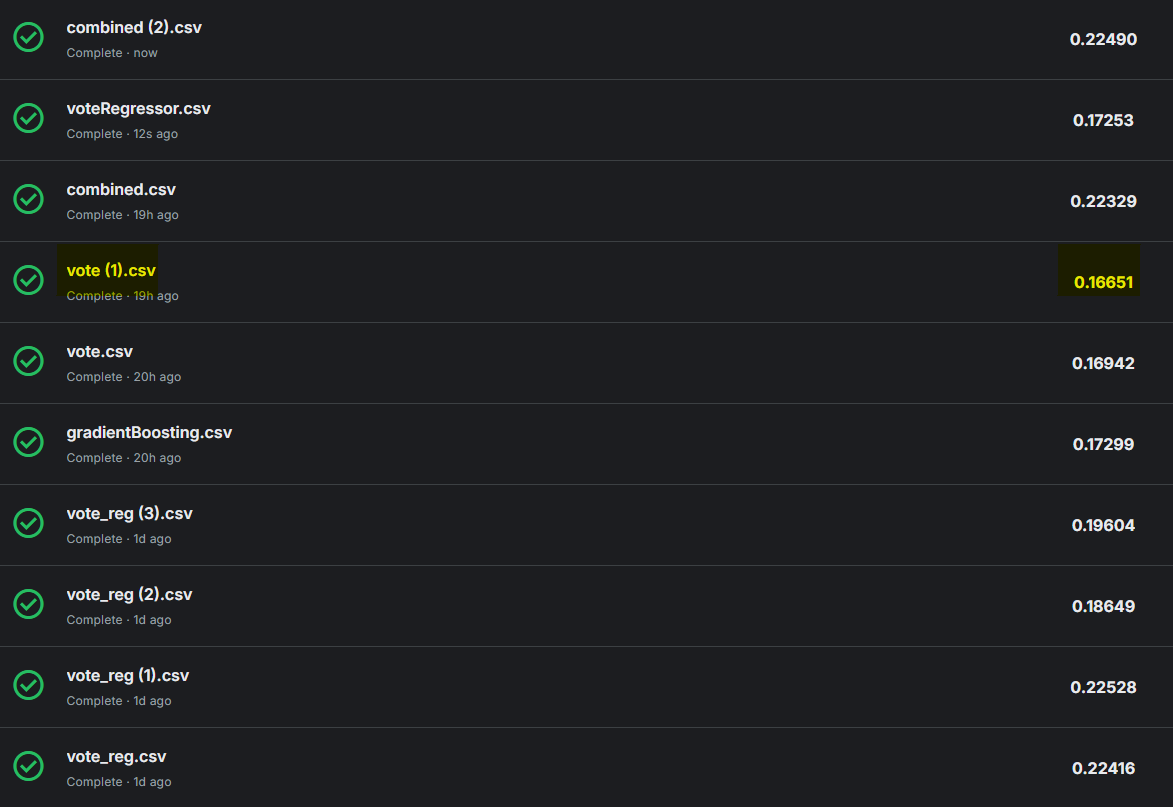

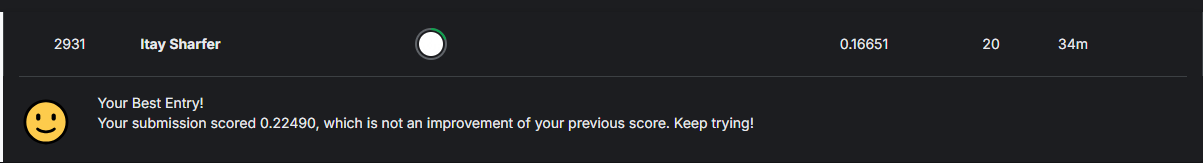

<div style="font-size:30px;">
References
    </div>

<div style="font-size:20px;">
<br>1. <a href="https://www.kaggle.com/code/cerberus4229/voting-regressor-with-pipelines"> Kaggle notebook - Voting Regressor</a>
<br>2. <a href="https://www.kaggle.com/code/pavansanagapati/ensemble-learning-techniques-tutorial#I-hope-by-now-you-had-a-fair-understanding-of-what-is-Ensemble-Learning-Methods.">Kaggle notebook - Ensembles</a>
<br>3.<a href="https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition#Identify-the-best-performing-model"> Kaggle notebook </a>
<br> Python functions and library functions were taken from the lab notebooks.
</div>